<a href="https://colab.research.google.com/github/jaidatta71/ML---Berkeley/blob/main/Comparing_classifiers_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import metrics
%matplotlib inline
import seaborn as sns
import scipy.stats as st
import missingno as msno
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency


!pip install category_encoders
import category_encoders as ce

import numpy as np
import pandas as pd
import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.4 MB/s eta 0:00:00


## Load data

In [3]:
bank = pd.read_csv('/content/drive/MyDrive/module17_starter/data/bank-additional-full.csv')
bank[['y']].value_counts()

,count
y,
no,36548
yes,4640


## 3. Data Clean up:
Drop duplicate records

In [4]:
bank = bank.drop_duplicates()

In [5]:
bank.shape

(41176, 21)

## List the Numeric and Object columns

In [6]:
cat_cols = bank.select_dtypes(include=['object']).columns.tolist()
if 'y' in cat_cols:
    cat_cols.remove('y')
num_cols = bank.select_dtypes(include=[np.number]).columns.tolist()
print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)

print(type(cat_cols))


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
<class 'list'>


In [ ]:
## OUTLIERS Treatment
#bank.plot(kind="box", subplots=True, figsize=(15, 25))
#for col in num_cols:
#    Q1 = bank[col].quantile(0.25)
#    Q3 = bank[col].quantile(0.75)
#    IQR = Q3 - Q1
#    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
#    bank = bank[(bank[col] >= lower) & (bank[col] <= upper)]

### Treat missing values
### Impute numeric -> median, categorical -> most_frequent

In [11]:
df2 = bank.copy()
for c in cat_cols:
    df2[c] = df2[c].replace('unknown', np.nan)

print("\nCounts of previously 'unknown' (now NaN) per categorical column:")
display(df2[cat_cols].isna().sum().sort_values(ascending=False))

# Impute numeric -> median, categorical -> most_frequent
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
df2[num_cols] = num_imputer.fit_transform(df2[num_cols])
df2[cat_cols] = cat_imputer.fit_transform(df2[cat_cols])

df2['y_bin'] = (df2['y'] == 'yes').astype(int)
X = df2.drop(columns=['y','y_bin'])
y = df2['y_bin']
df2.info()


print("\nCounts of after imputation:")
display(df2[cat_cols].isna().sum().sort_values(ascending=False))


Counts of previously 'unknown' (now NaN) per categorical column:


,0
default,8596
education,1730
housing,990
loan,990
job,330
marital,80
contact,0
month,0
day_of_week,0
poutcome,0


<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  float64
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  float64
 11  campaign        41176 non-null  float64
 12  pdays           41176 non-null  float64
 13  previous        41176 non-null  float64
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0
poutcome,0


### Is there a Correlation among numeric features


Numeric correlation matrix (sample):


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,0.01,-0.02
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.03,-0.04
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.30,0.37
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.45,-0.50
emp.var.rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.97,0.91
cons.price.idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.69,0.52
cons.conf.idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.28,0.10
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,1.00,0.95
nr.employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,1.00


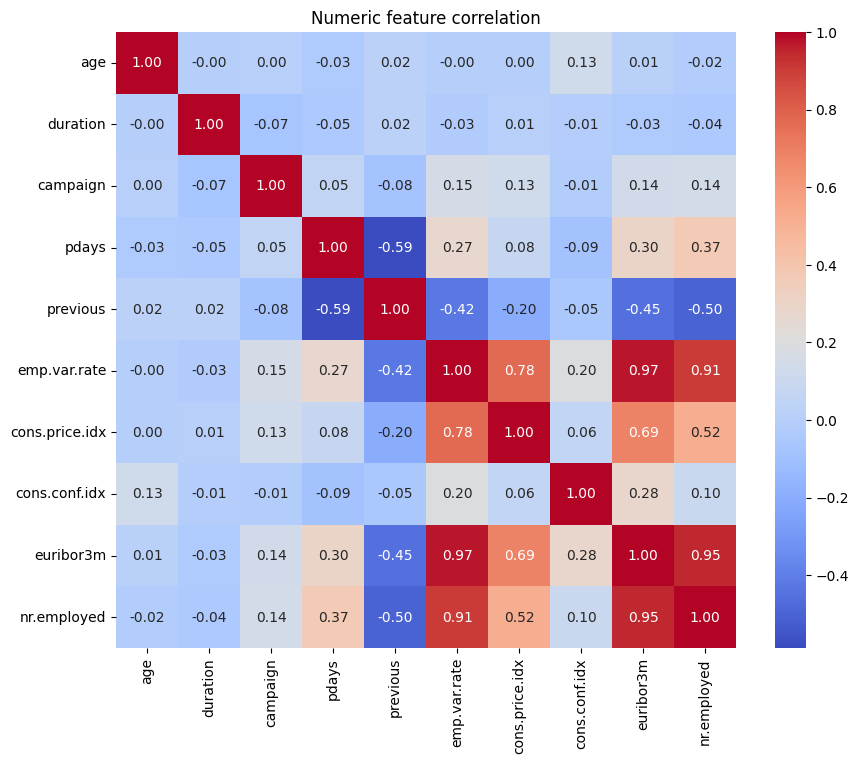

In [17]:
# Correlation among numeric features
corr = df2[num_cols].corr()
print("\nNumeric correlation matrix (sample):")
display(corr.round(2))
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Numeric feature correlation")
plt.show()

### PLOTs

#### COUNT PLOTS

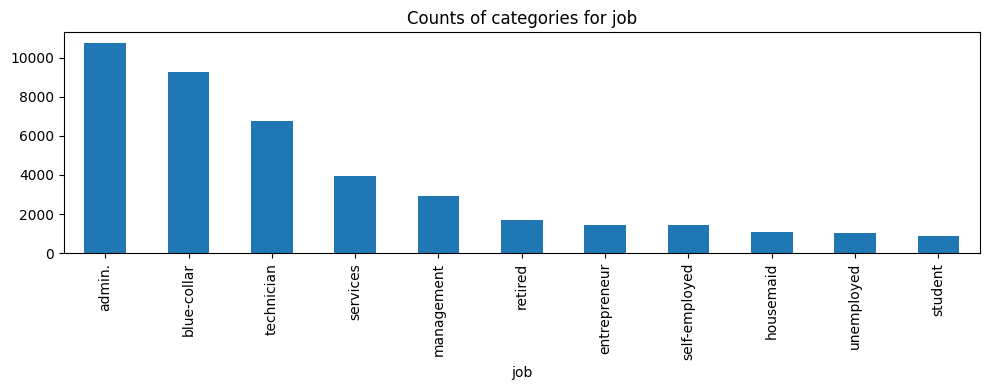

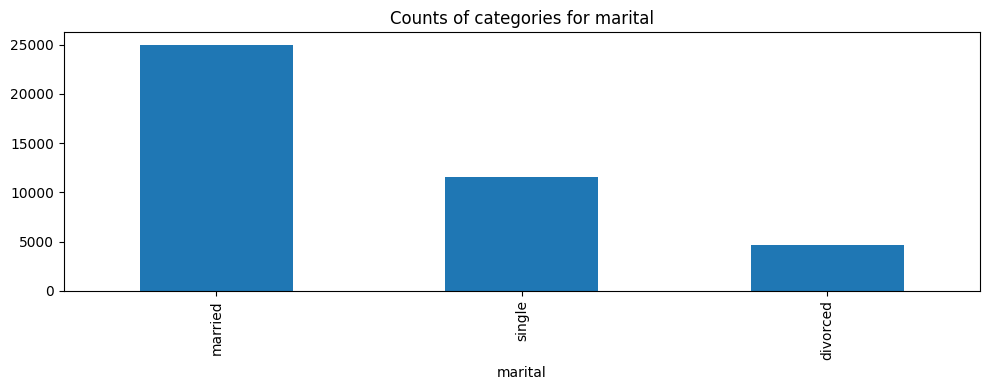

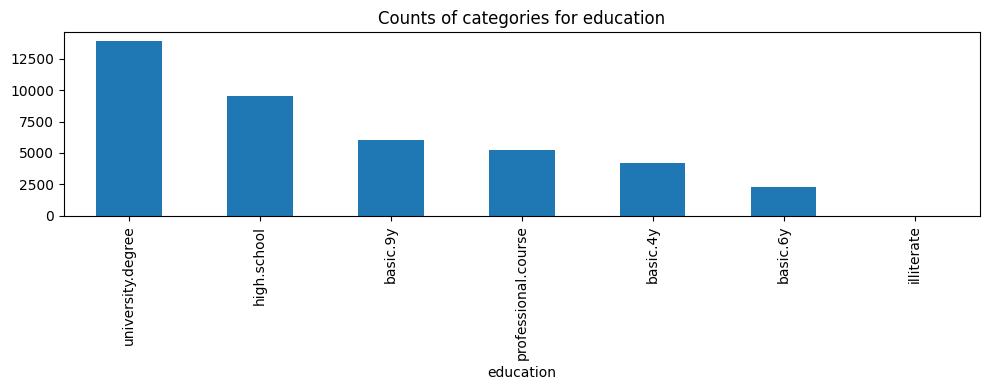

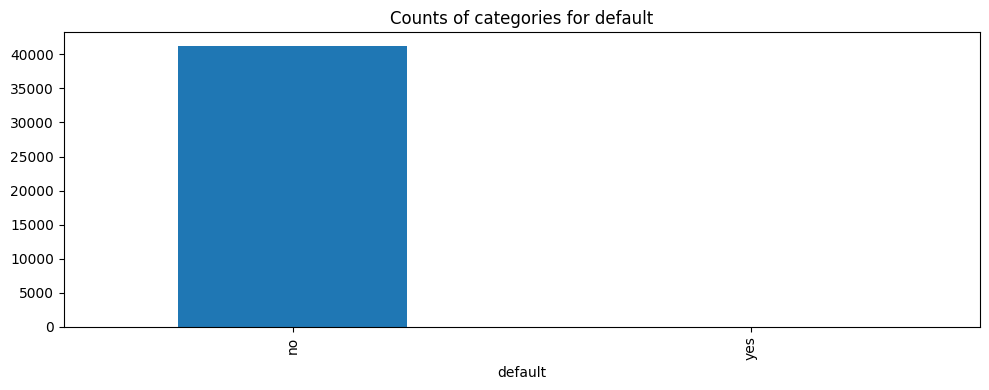

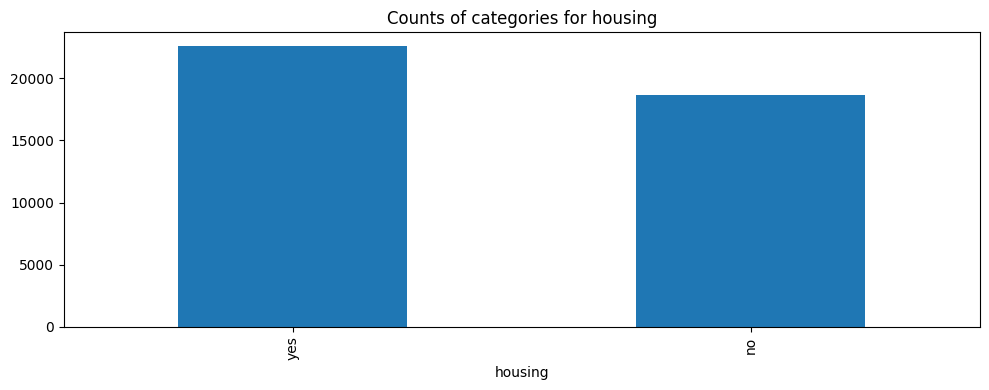

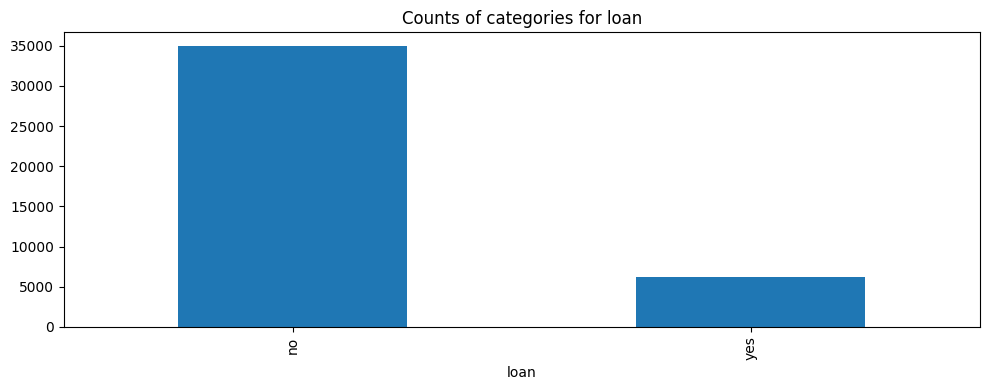

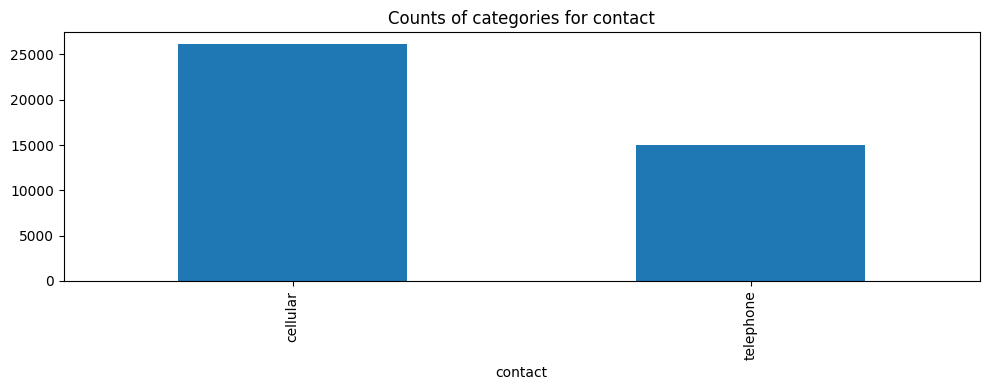

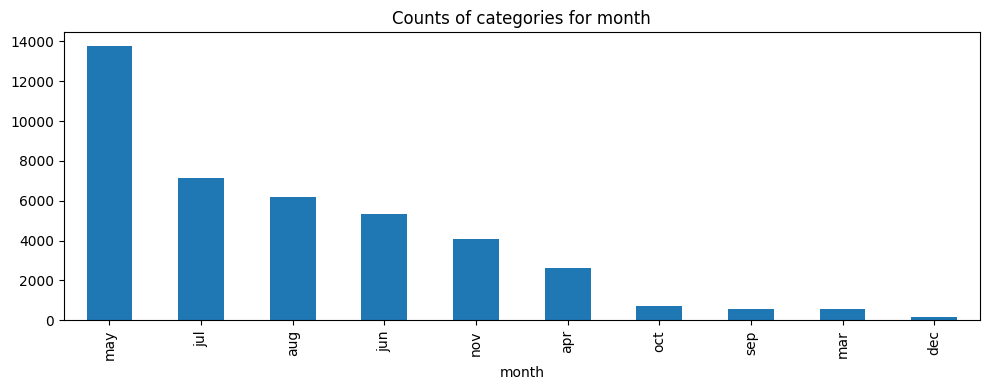

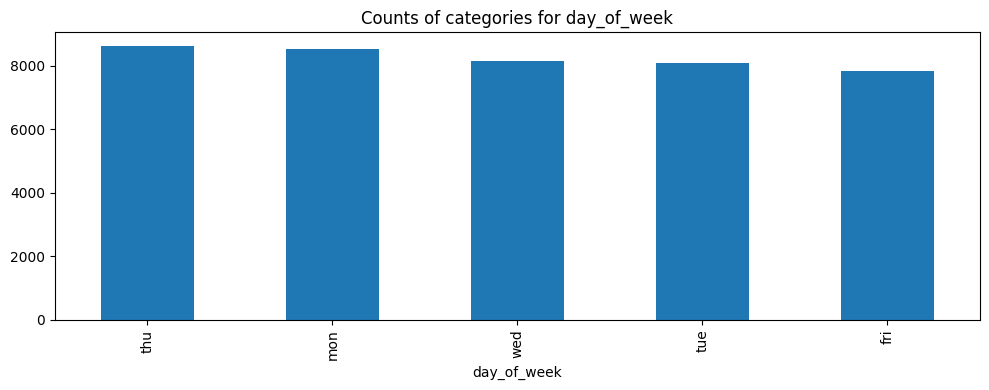

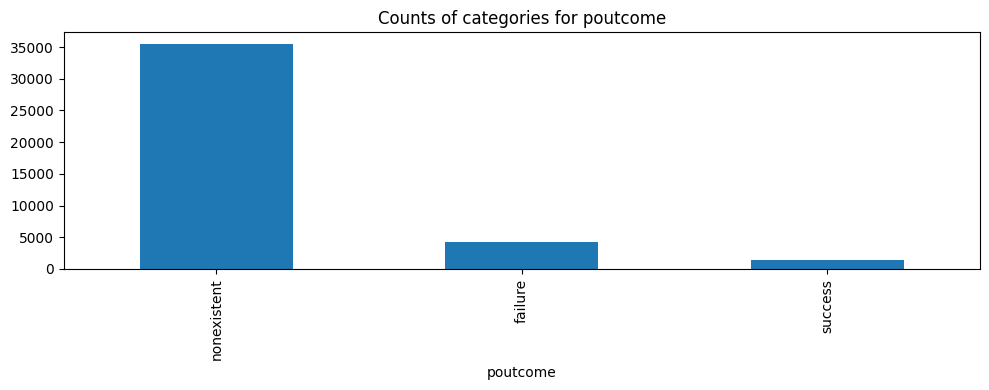

In [18]:

for c in cat_cols:
    plt.figure(figsize=(10,4))
    df2[c].value_counts().head(30).plot(kind='bar')
    plt.title(f"Counts of categories for {c}")
    plt.tight_layout()

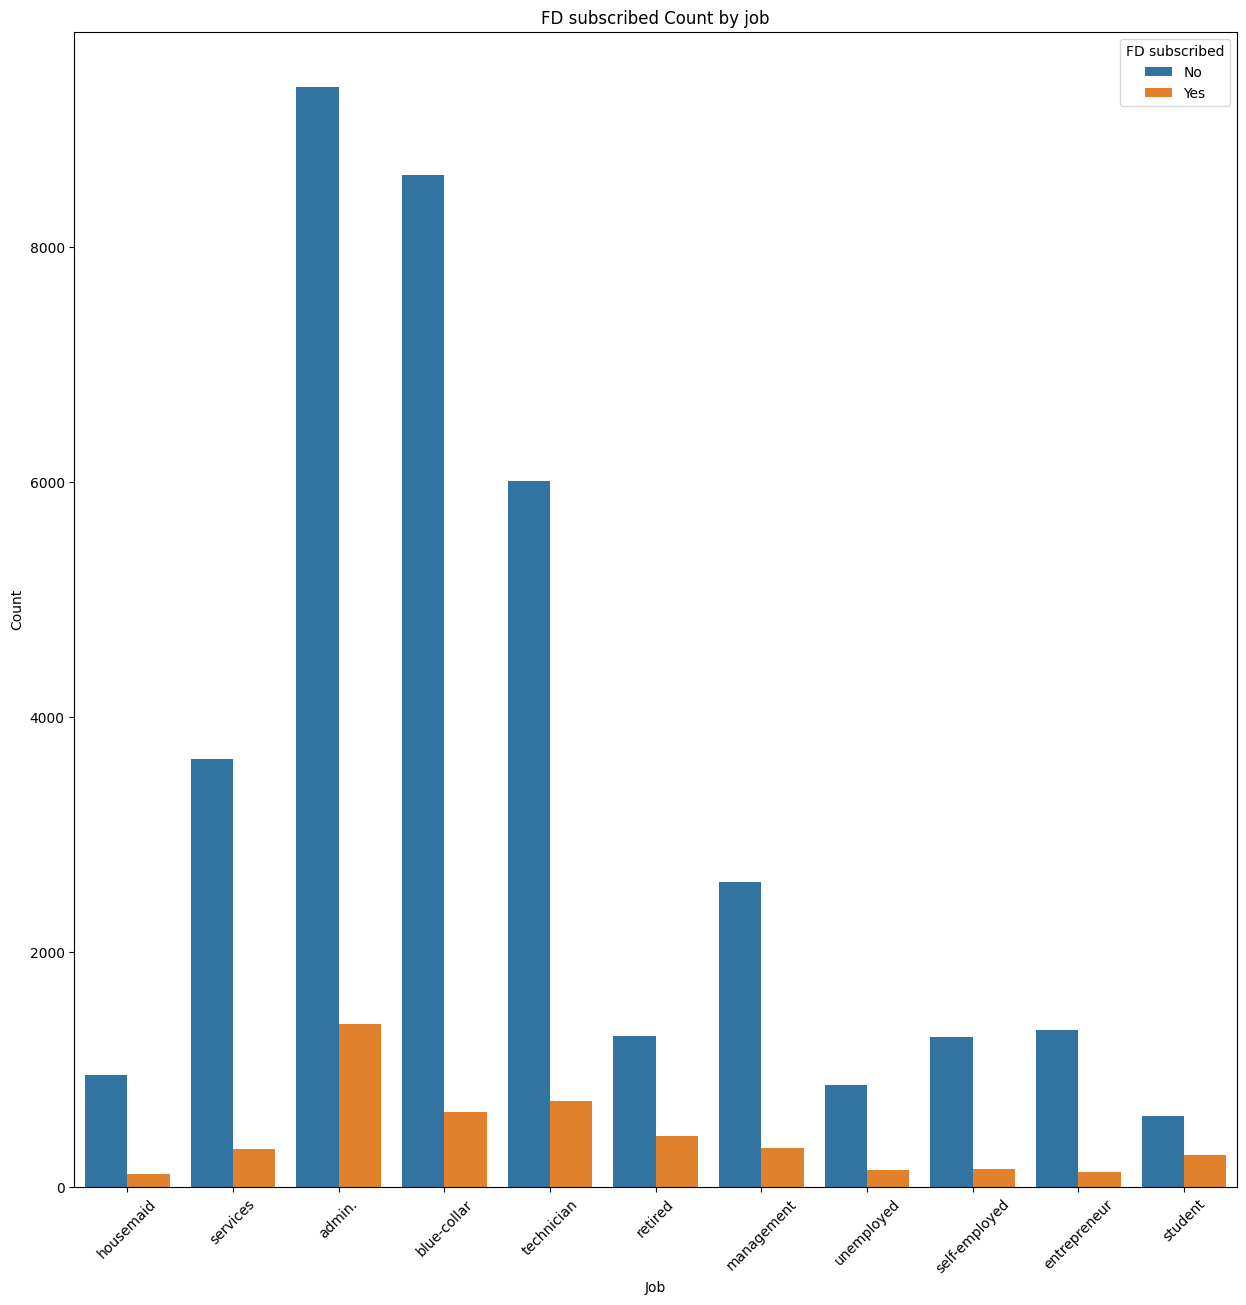

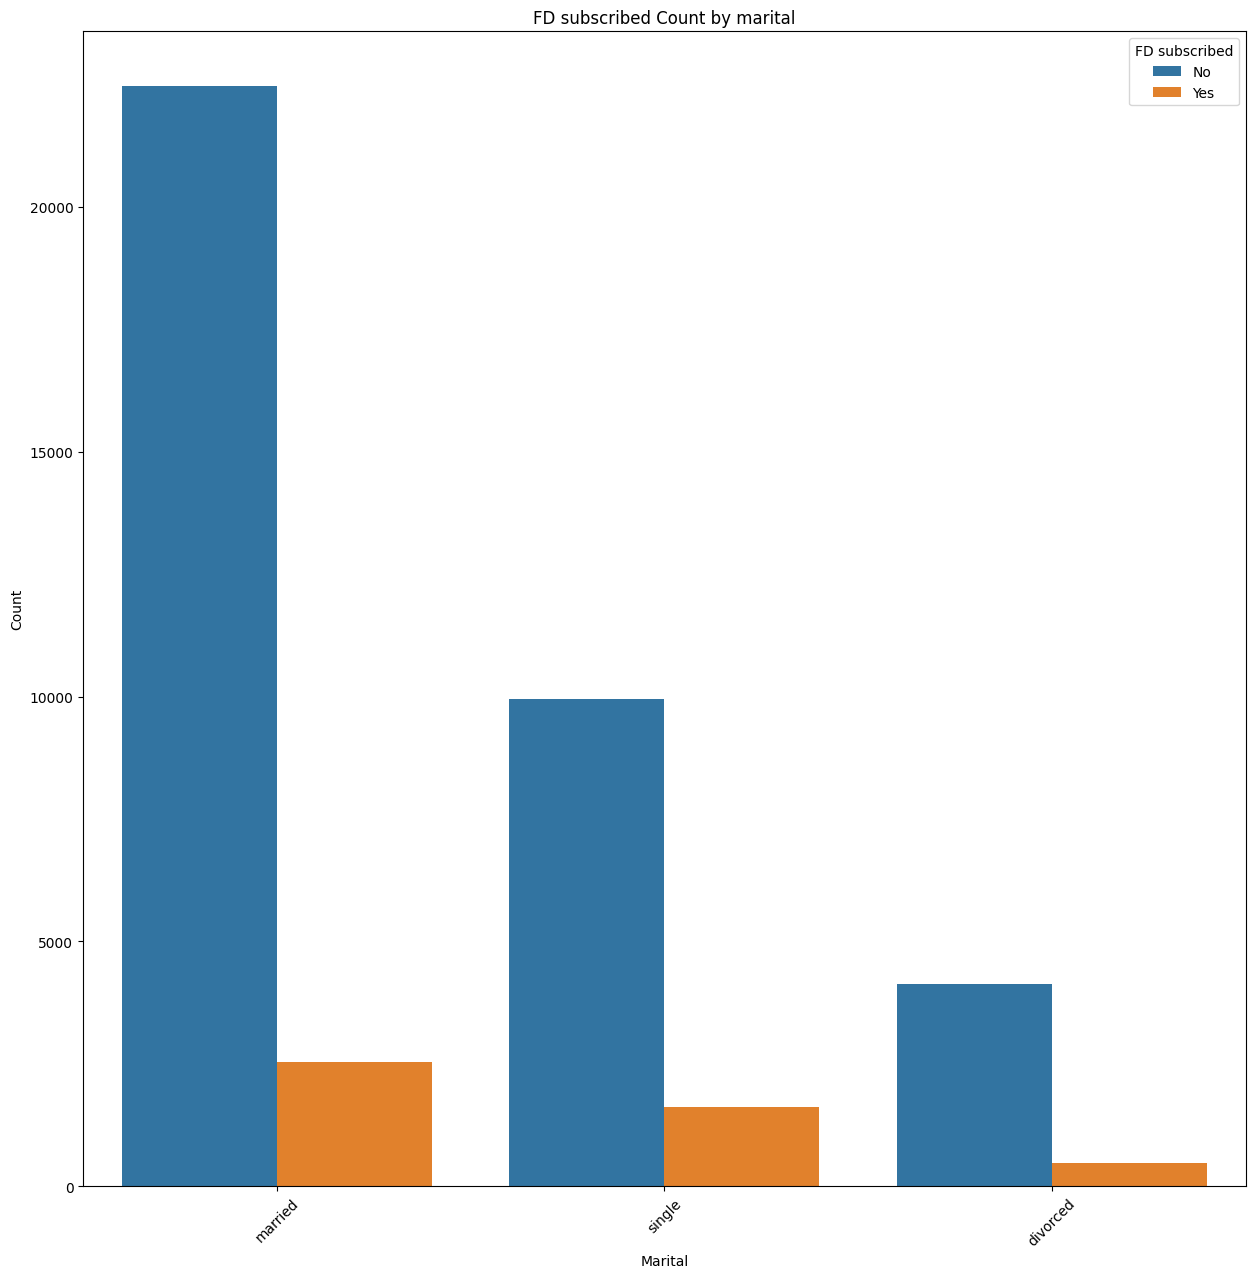

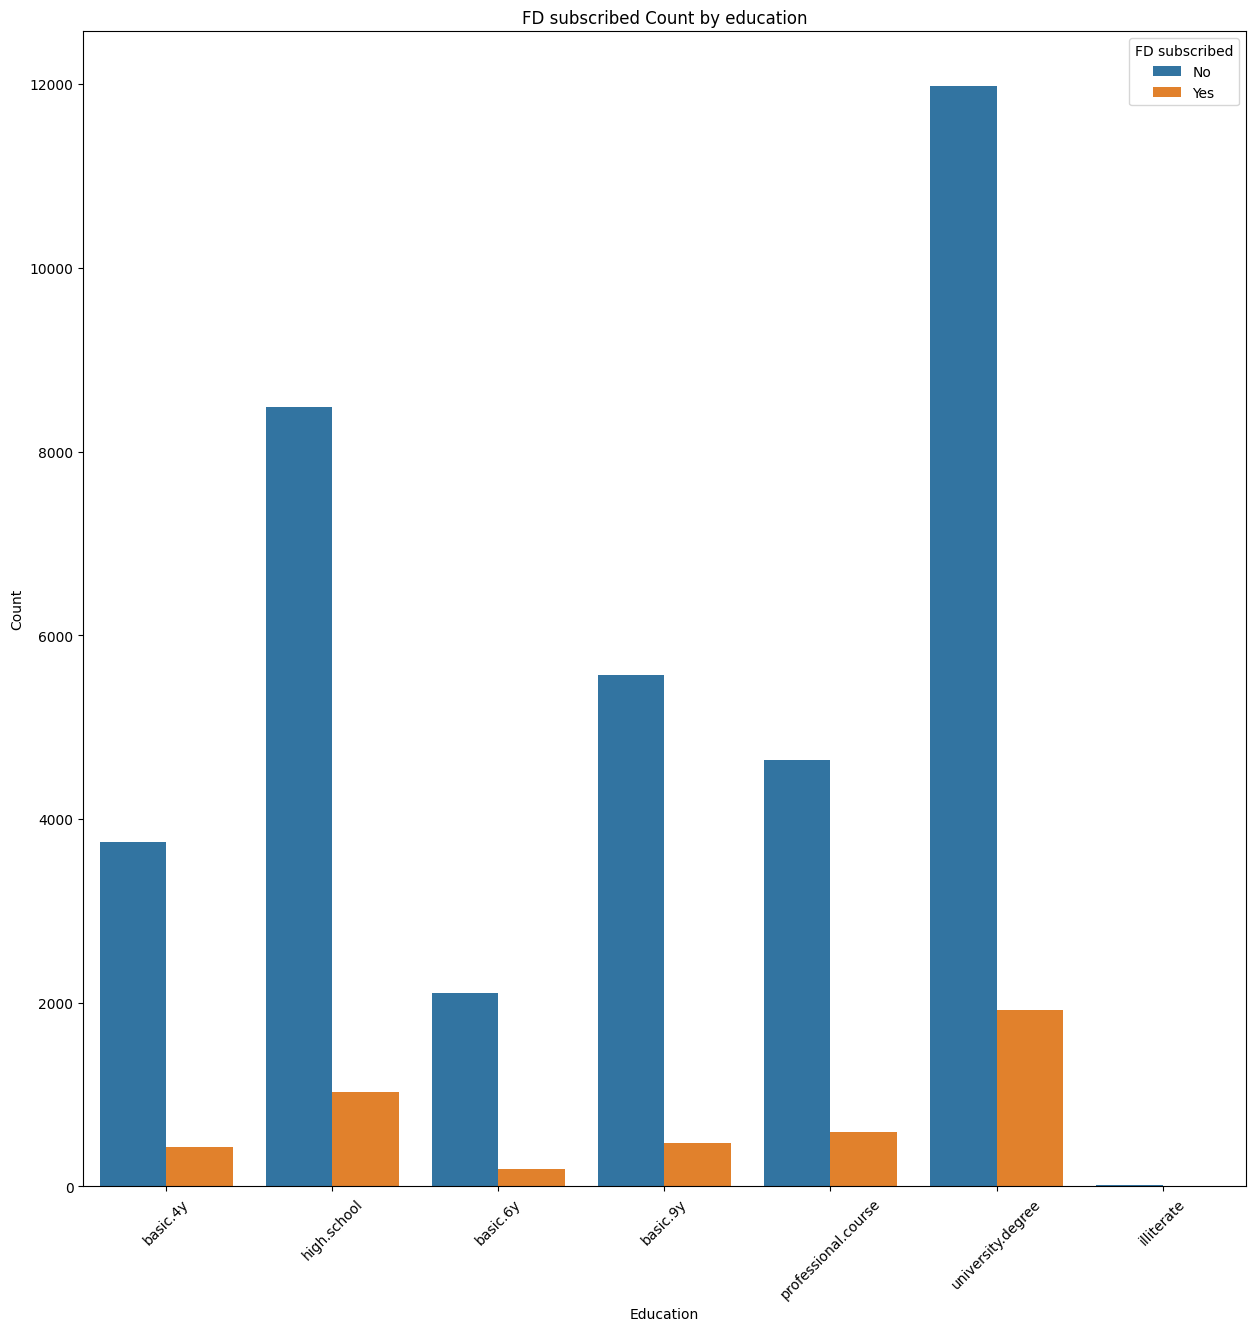

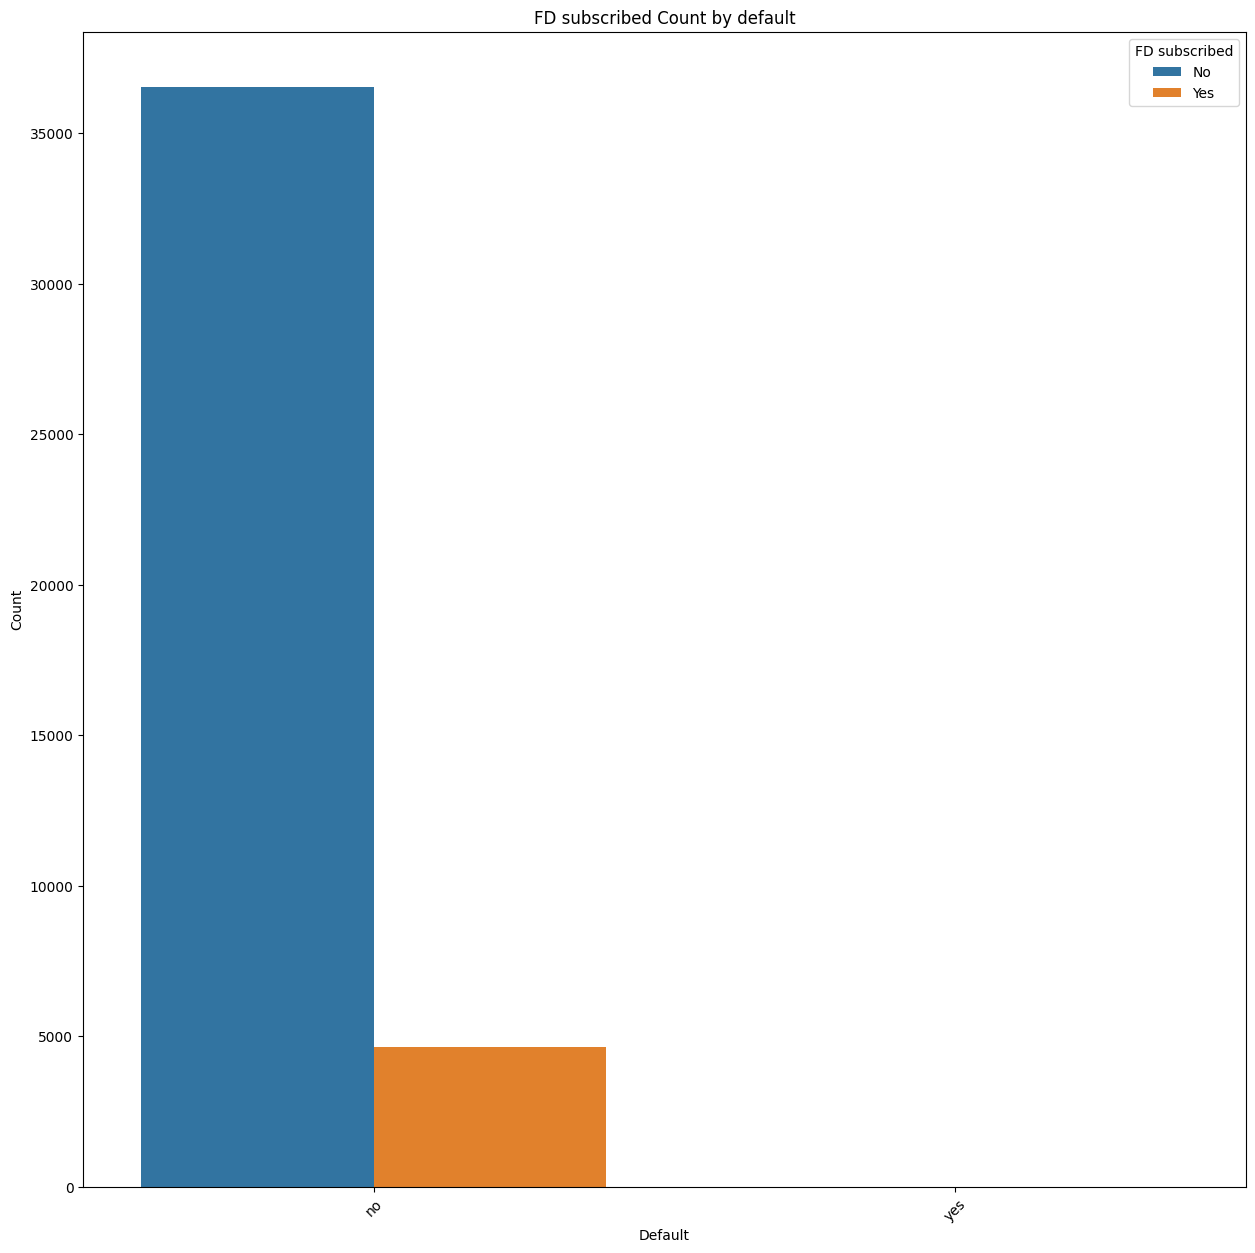

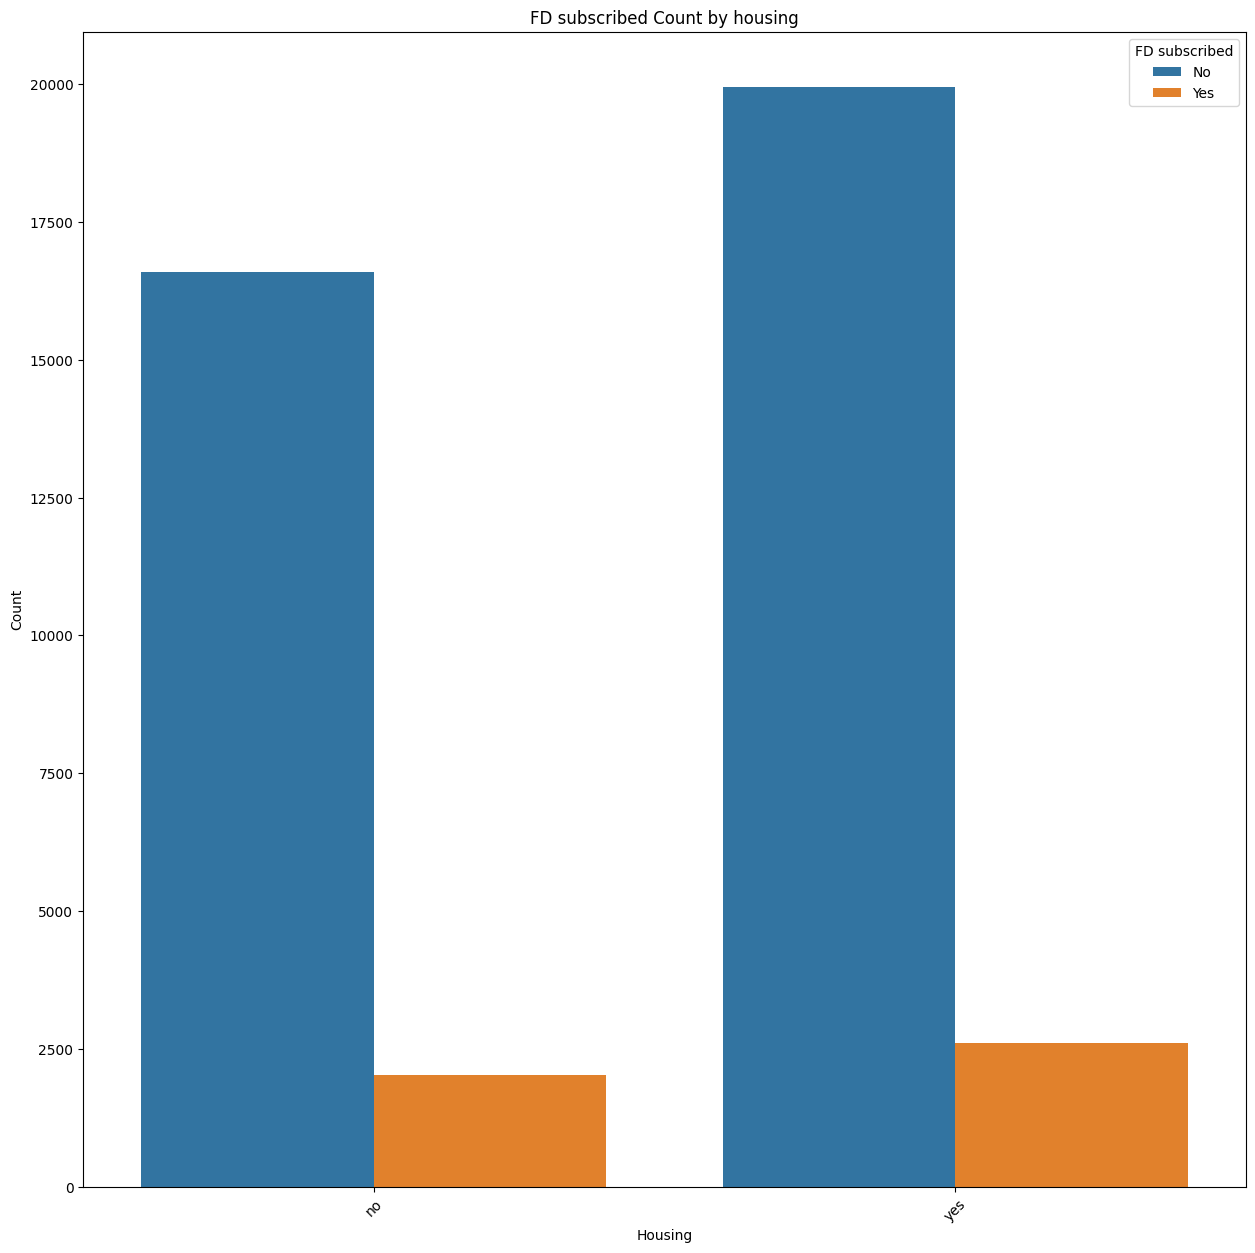

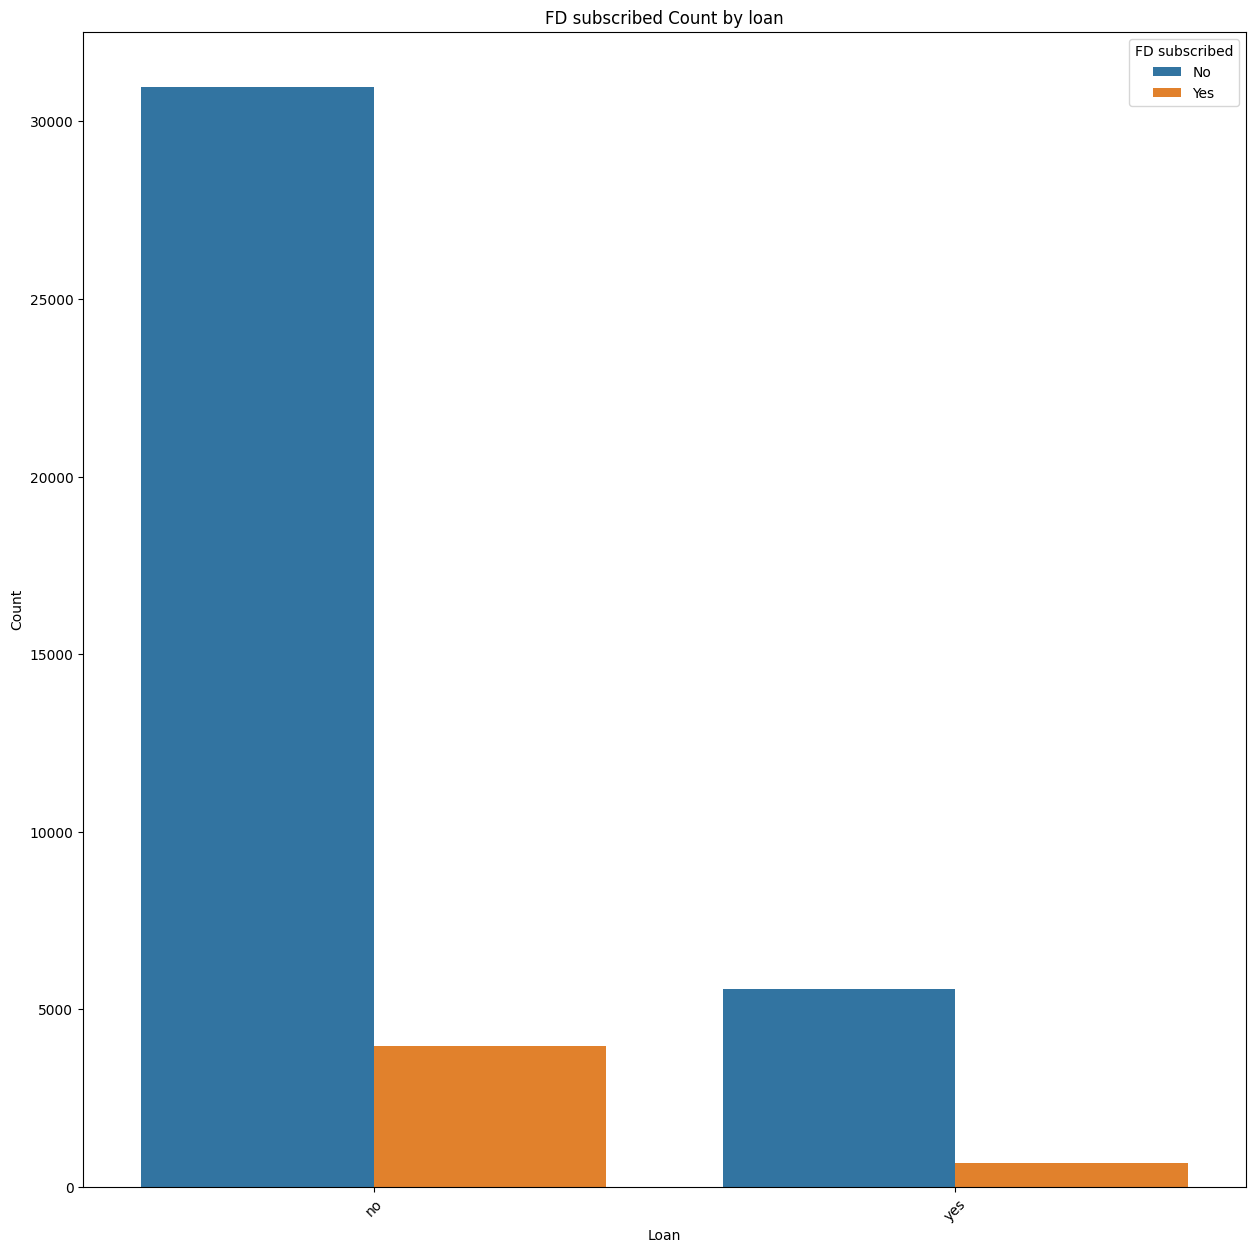

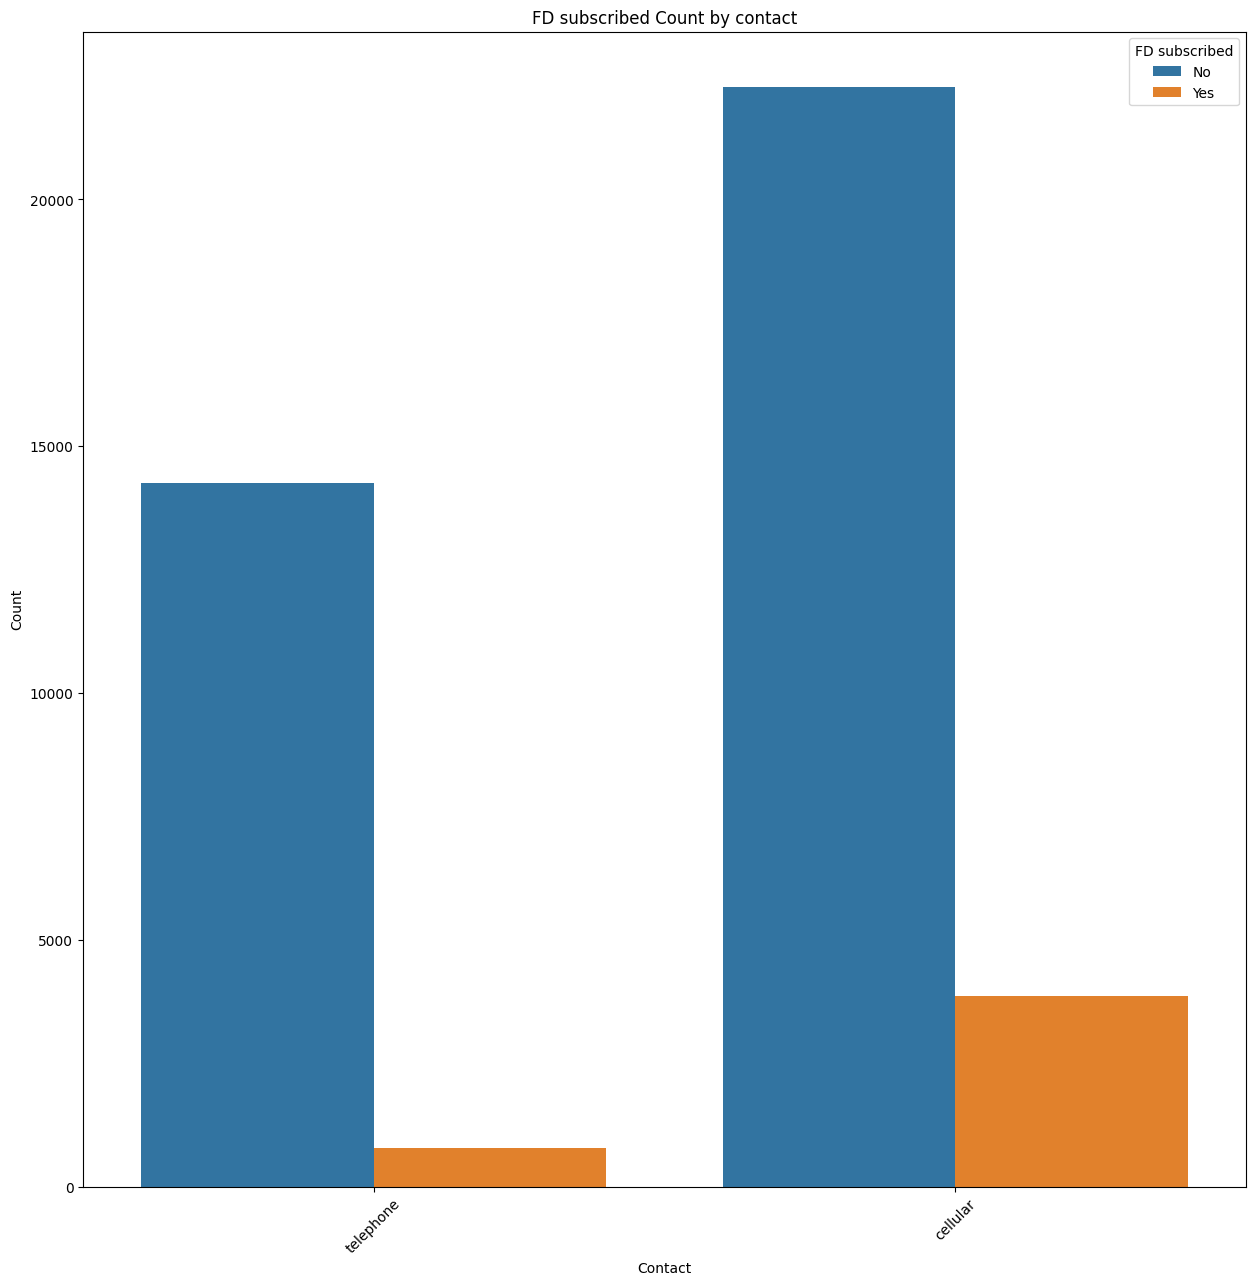

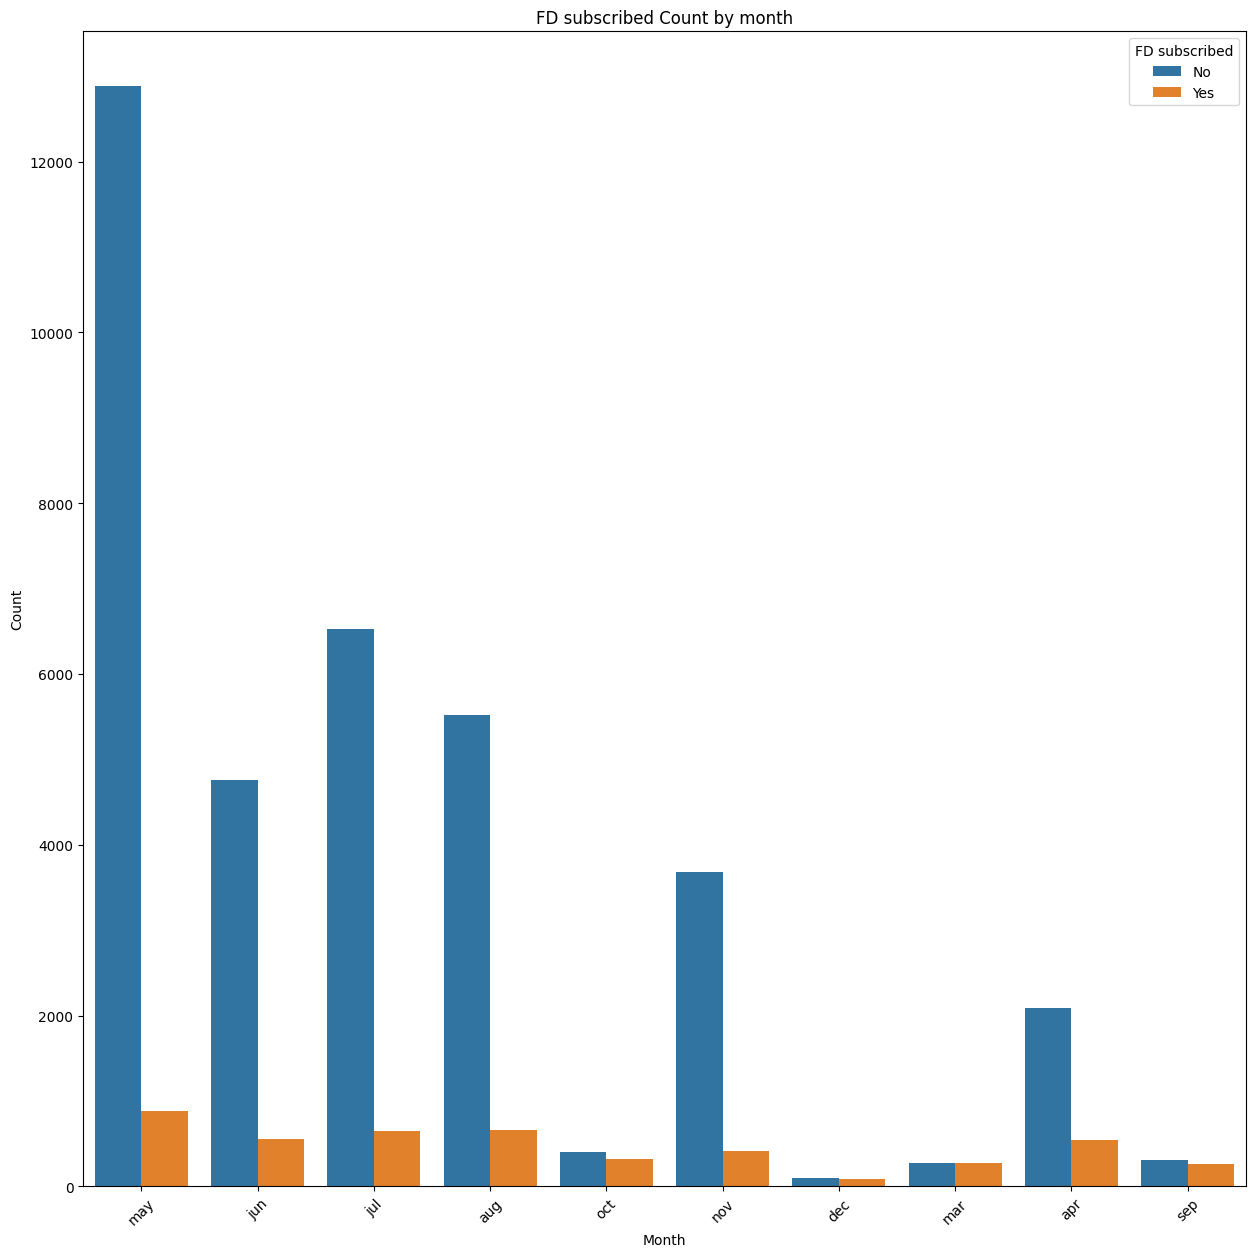

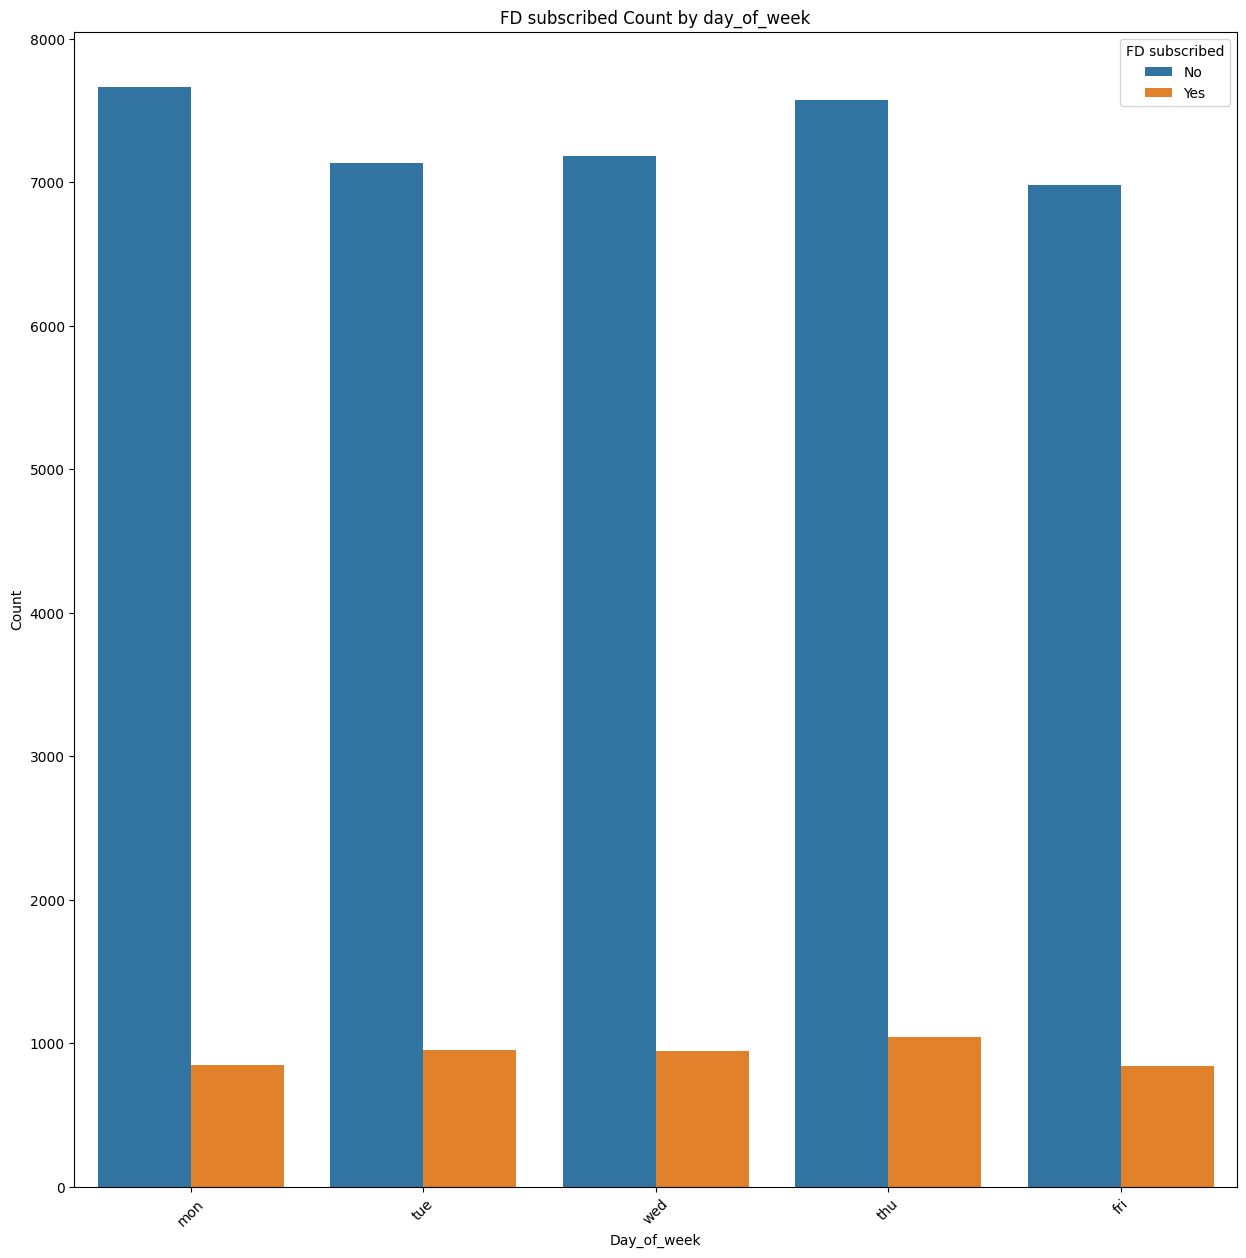

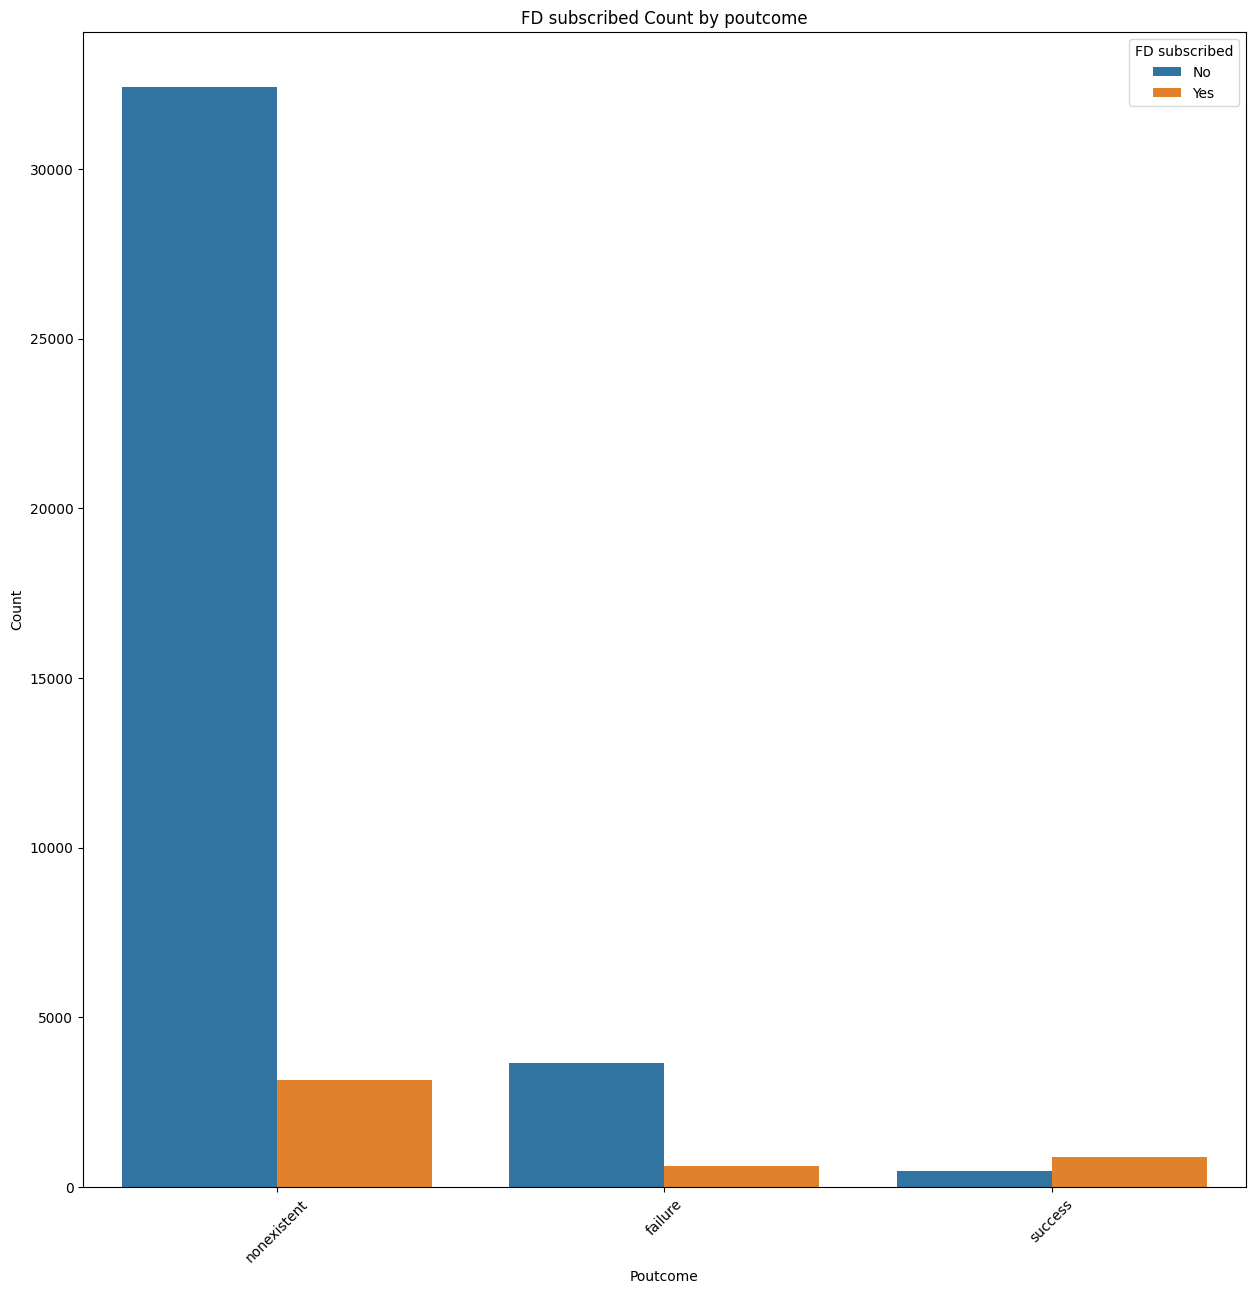

In [19]:
target = 'y'

for col in cat_cols:
    plt.figure(figsize=(15,15))
    sns.countplot(data=df2, x=col, hue=target)
    plt.title(f'FD subscribed Count by {col}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.legend(title='FD subscribed', labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    plt.show()

In [20]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df2[col].dropna(), kde=True)
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
    plt.close()

## T test - to identify numeric features which impact target

In [21]:
tt_results = []
for col in num_cols:
    a = df2.loc[df2['y_bin']==1, col]
    b = df2.loc[df2['y_bin']==0, col]
    tstat, pval = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
    tt_results.append({'feature': col, 't_stat': float(tstat), 'p_value': float(pval)})
pd.DataFrame(tt_results).sort_values('p_value')


,feature,t_stat,p_value
1,duration,55.498364,0.000000e+00
5,emp.var.rate,-59.116619,0.000000e+00
9,nr.employed,-60.958907,0.000000e+00
8,euribor3m,-62.560284,0.000000e+00
3,pdays,-32.251530,1.649735e-206
4,previous,28.125562,1.683775e-161
6,cons.price.idx,-24.066952,9.723526e-122
2,campaign,-20.247923,4.219168e-89
7,cons.conf.idx,8.622672,8.546282e-18
0,age,4.775311,1.843009e-06


## Chi-square Test - to identify char features which impact target
#### p-value: 0.000000e+00 means Strong Evidence Against the Null Hypothesis: This result provides overwhelming evidence to reject the null hypothesis. The null hypothesis states there is no effect or no difference between groups

In [22]:
chi_results = []
for c in cat_cols:
    cont = pd.crosstab(df2[c], df2['y_bin'])
    try:
        chi2, p, dof, ex = chi2_contingency(cont)
    except Exception:
        chi2, p = np.nan, np.nan
    chi_results.append({'feature': c, 'chi2': float(chi2) if not np.isnan(chi2) else np.nan, 'p_value': float(p) if not np.isnan(p) else np.nan})
pd.DataFrame(chi_results).sort_values('p_value')




,feature,chi2,p_value
7,month,3103.032672,0.000000e+00
9,poutcome,4230.143428,0.000000e+00
0,job,960.758781,5.292143e-200
6,contact,862.080737,1.718741e-189
2,education,191.908091,9.996214e-39
1,marital,121.087681,5.083282e-27
8,day_of_week,26.054244,3.085755e-05
4,housing,5.044191,2.470864e-02
5,loan,0.786737,3.750887e-01
3,default,0.000000,1.000000e+00


## Class Imbalance check

In [23]:
pos_ratio = y.mean()
imbalance = "not severe"
if pos_ratio < 0.05 or pos_ratio > 0.95:
    imbalance = "severe"
elif pos_ratio < 0.20 or pos_ratio > 0.80:
    imbalance = "moderate"
print("Positive class ratio:", pos_ratio, "->", imbalance)

Positive class ratio: 0.11266271614532737 -> moderate


## Encoding using OneHotEncoder

In [24]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
df2['y'] = le.fit_transform(df2['y'])  # 'yes' -> 1, 'no' -> 0

# One-hot encode categorical features
#df_encoded = pd.get_dummies(df.drop('y', axis=1), drop_first=True)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(df2[cat_cols])

# Create encoded DataFrame
df_encoded = pd.DataFrame(
    encoded,
    columns=ohe.get_feature_names_out(cat_cols),
    index=df2.index  # preserve original row indices
)

# Combine encoded categorical columns with remaining numeric columns
df_encoded  = pd.concat([df2.drop(columns=cat_cols), df_encoded], axis=1)

# Add target back
df_encoded['y'] = df2['y']

In [25]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  float64
 1   duration                       41176 non-null  float64
 2   campaign                       41176 non-null  float64
 3   pdays                          41176 non-null  float64
 4   previous                       41176 non-null  float64
 5   emp.var.rate                   41176 non-null  float64
 6   cons.price.idx                 41176 non-null  float64
 7   cons.conf.idx                  41176 non-null  float64
 8   euribor3m                      41176 non-null  float64
 9   nr.employed                    41176 non-null  float64
 10  y                              41176 non-null  int64  
 11  y_bin                          41176 non-null  int64  
 12  job_admin.                     41176 non-null  floa

### Drop columns not related or impact Target

In [26]:
df_encoded = df_encoded.drop(columns =['day_of_week_fri','day_of_week_mon','day_of_week_tue','day_of_week_thu','day_of_week_wed'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  float64
 1   duration                       41176 non-null  float64
 2   campaign                       41176 non-null  float64
 3   pdays                          41176 non-null  float64
 4   previous                       41176 non-null  float64
 5   emp.var.rate                   41176 non-null  float64
 6   cons.price.idx                 41176 non-null  float64
 7   cons.conf.idx                  41176 non-null  float64
 8   euribor3m                      41176 non-null  float64
 9   nr.employed                    41176 non-null  float64
 10  y                              41176 non-null  int64  
 11  y_bin                          41176 non-null  int64  
 12  job_admin.                     41176 non-null  floa

# 11. Split data into train/test

In [27]:
X = df_encoded.drop(columns=['y','y_bin'])
y = df_encoded['y_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
df_encoded.shape

(41176, 54)

## Base Line Model: Logistic Regression

In [30]:
lr     = LogisticRegression(max_iter=10000, random_state=42).fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("LR Model Accuracy:", accuracy)

LR Model Accuracy: 0.9089363768819816


## Modelling with KNN, SVM, and Decision tree


 Logistic Regression
Accuracy: 0.9089

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7308
           1       0.65      0.42      0.51       928

    accuracy                           0.91      8236
   macro avg       0.79      0.69      0.73      8236
weighted avg       0.90      0.91      0.90      8236


Confusion Matrix for Test Set:
[[7098  210]
 [ 540  388]]


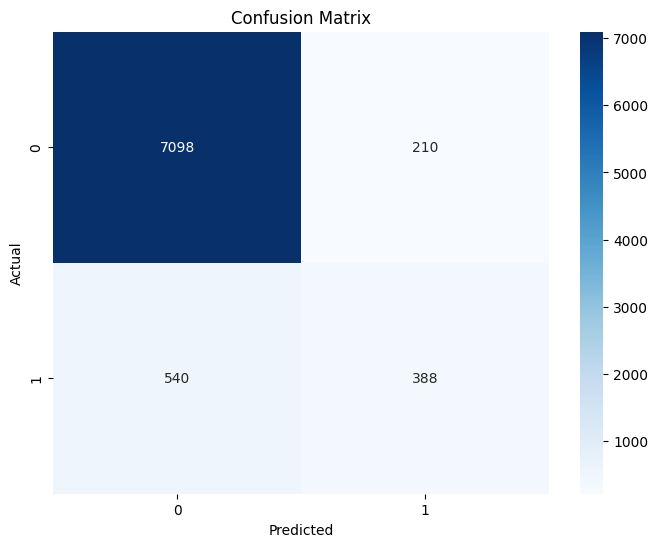


 K-Nearest Neighbors
Accuracy: 0.9043

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7308
           1       0.59      0.49      0.54       928

    accuracy                           0.90      8236
   macro avg       0.76      0.73      0.74      8236
weighted avg       0.90      0.90      0.90      8236


Confusion Matrix for Test Set:
[[6989  319]
 [ 469  459]]


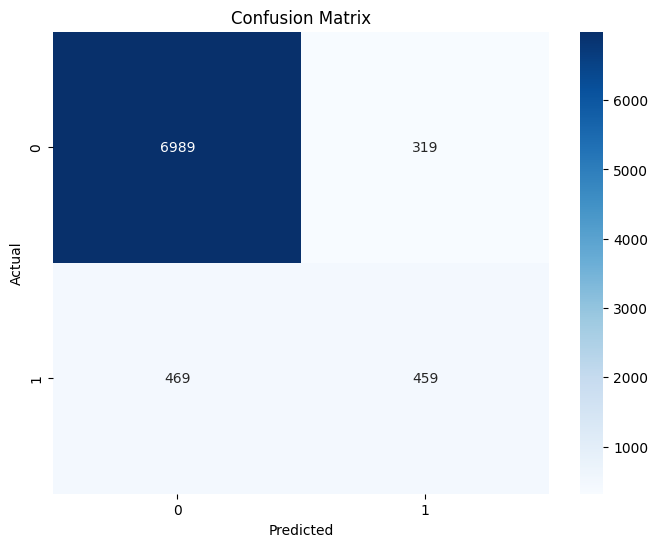


 Decision Tree
Accuracy: 0.8889

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7308
           1       0.51      0.54      0.52       928

    accuracy                           0.89      8236
   macro avg       0.72      0.74      0.73      8236
weighted avg       0.89      0.89      0.89      8236


Confusion Matrix for Test Set:
[[6818  490]
 [ 425  503]]


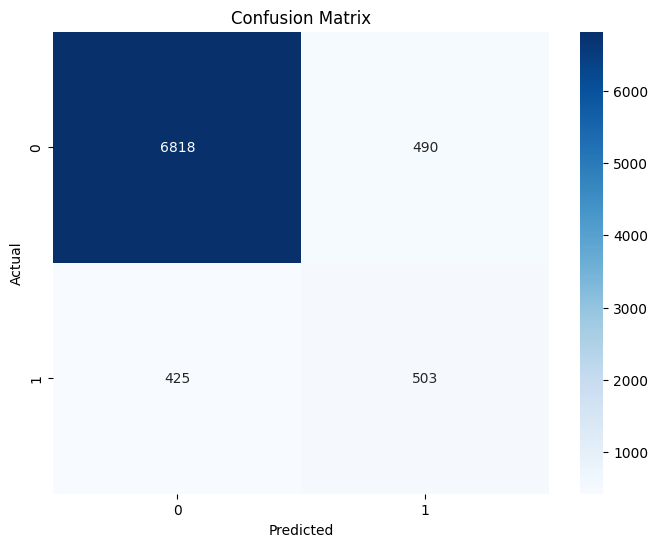


 Support Vector Machine
Accuracy: 0.8949

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7308
           1       0.60      0.21      0.31       928

    accuracy                           0.89      8236
   macro avg       0.75      0.59      0.62      8236
weighted avg       0.87      0.89      0.87      8236


Confusion Matrix for Test Set:
[[7179  129]
 [ 737  191]]


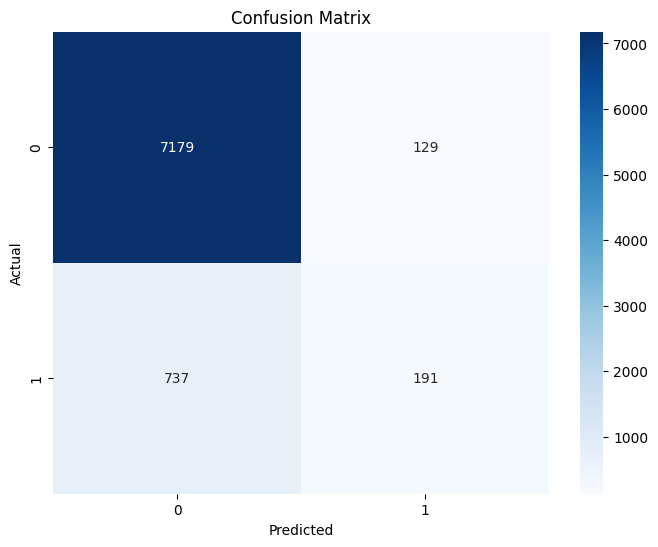

In [29]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', random_state=42)
}

# --- Train and Evaluate Each Model ---
#sv     = SVC(kernel='rbf', random_state=42).fit(X_train, y_train)
#y_pred = sv.predict(X_test)

# Calculate accuracy
#accuracy = metrics.accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n {name}")
    print(f"Accuracy: {acc:.4f}")

# Use other metrics as needed (e.g., precision, recall, F1-score)
# Generate a classification report for the test set
    print("\nClassification Report for Test Set:")
    print(classification_report(y_test, y_pred))

# Generate a confusion matrix for the test set
    print("\nConfusion Matrix for Test Set:")
    print(confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

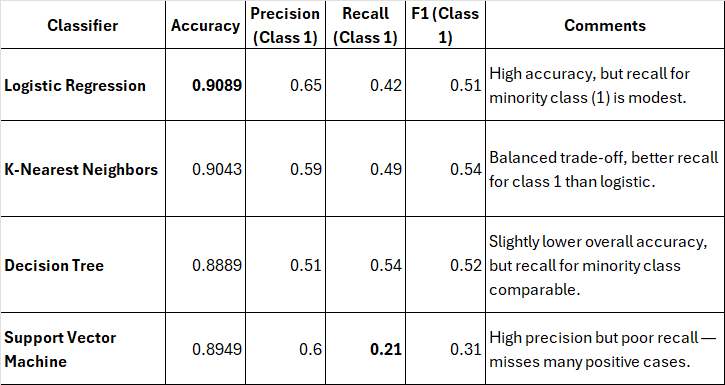

**Best Classifier**

If the goal is overall accuracy,
→  **Logistic Regression **(90.9%) performs best.

If the goal is detecting positive cases (class 1)
→  **KNN or Decision Tree** are better, since they provide higher recall and F1 for the minority class.

**Recommended Choice:**

K-Nearest Neighbors (KNN) is the most balanced classifier here, with:

High accuracy (90.4%)
Best F1 for the minority class (0.54)
Strong recall (0.49), meaning fewer false negatives.